# Deep Learning - Lista 2

In [107]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_datasets as tf_ds
import io
import math


from numpy.random.mtrand import uniform, randint

from sklearn import metrics

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

## 2° Questão:

Implementem duas redes neurais artificiais para o problema de classificação de dígitos escritos à mão utilizando a base de dados do MNIST, disponível em:
http://yann.lecun.com/exdb/mnist. A primeira rede deve ser uma rede neural perceptron de múltiplas camadas clássica, e a segunda deve ser uma Rede Neural Convolucional (CNN).
Compare o desempenho das duas redes analisando a curva de erro médio e a matriz de confusão.

### Download das Instâncias

In [108]:
(train, test), ds_info = tf_ds.load('mnist', split=['train', 'test'], shuffle_files=True, as_supervised=True, with_info=True)
print('Split train/test:')
print('\t size train: ', len(train))
print('\t size test: ', len(test),'\n')

tf_ds.as_dataframe(train.take(6), ds_info)

Split train/test:
	 size train:  60000
	 size test:  10000 



,image,label
0,,4
1,,1
2,,0
3,,7
4,,8
5,,1


### Pre-Processamento das instâncias 

In [109]:
# Reshaping and normalize input 
def reshape(image, label):
  return tf.cast(image, tf.float32) / 255., label

# Dataset pipeline
def ds_pipeline(ds, ds_info, train=False):
  ds = ds.map(reshape)
  ds = ds.cache()
  if train is True: 
    ds = ds.shuffle(ds_info.splits['train'].num_examples)
  ds = ds.batch(100)
  ds = ds.prefetch(tf.data.AUTOTUNE)

  return ds

p_train = ds_pipeline(test, ds_info, True)
p_test = ds_pipeline(test, ds_info, False)

### Modelos

#### Multilayer Perceptron (MLP)

In [110]:

mlp_model = keras.Sequential()
mlp_model.add(layers.Flatten(input_shape=(28, 28)))
mlp_model.add(layers.Dense(100, activation='relu'))
mlp_model.add(layers.Dense(10))

optimizer = tf.keras.optimizers.SGD(learning_rate=0.02)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

mlp_model.compile(loss=loss, optimizer=optimizer, metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

with tf.device('/device:GPU:0'):
  mlp_hist = mlp_model.fit(p_train, epochs=150, validation_data=p_test, callbacks=[early_stopping])

Epoch 1/150
100/100 [==============================] - 2s 9ms/step - loss: 1.6170 - sparse_categorical_accuracy: 0.5838 - val_loss: 1.0888 - val_sparse_categorical_accuracy: 0.7870
Epoch 2/150
100/100 [==============================] - 0s 5ms/step - loss: 0.8634 - sparse_categorical_accuracy: 0.8173 - val_loss: 0.7043 - val_sparse_categorical_accuracy: 0.8451
Epoch 3/150
100/100 [==============================] - 0s 5ms/step - loss: 0.6238 - sparse_categorical_accuracy: 0.8533 - val_loss: 0.5567 - val_sparse_categorical_accuracy: 0.8650
Epoch 4/150
100/100 [==============================] - 0s 5ms/step - loss: 0.5187 - sparse_categorical_accuracy: 0.8729 - val_loss: 0.4805 - val_sparse_categorical_accuracy: 0.8815
Epoch 5/150
100/100 [==============================] - 0s 5ms/step - loss: 0.4582 - sparse_categorical_accuracy: 0.8843 - val_loss: 0.4328 - val_sparse_categorical_accuracy: 0.8902
Epoch 6/150
100/100 [==============================] - 0s 4ms/step - loss: 0.4185 - sparse_cate

In [111]:
mlp_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_9 (Flatten)         (None, 784)               0         
                                                                 
 dense_25 (Dense)            (None, 100)               78500     
                                                                 
 dense_26 (Dense)            (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


#### Convolutional Neural Network (CNN)

In [112]:
cnn_model = keras.Sequential()
cnn_model.add(layers.Conv2D(filters=32, kernel_size=3))
cnn_model.add(layers.Conv2D(filters=32, kernel_size=3))
cnn_model.add(layers.MaxPooling2D(pool_size=(2,2)))
cnn_model.add(layers.Dropout(0.25))
cnn_model.add(layers.Conv2D(filters=64, kernel_size=3))
cnn_model.add(layers.Conv2D(filters=64, kernel_size=3))
cnn_model.add(layers.MaxPooling2D(pool_size=(2,2)))
cnn_model.add(layers.Dropout(0.25))
cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(128, activation='relu'))
cnn_model.add(layers.Dropout(0.25))
cnn_model.add(layers.Dense(32, activation='relu'))
cnn_model.add(layers.Dense(10))

optimizer = tf.keras.optimizers.SGD(learning_rate=0.02)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

cnn_model.compile(loss=loss, optimizer=optimizer, metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

with tf.device('/device:GPU:0'):
  cnn_hist = cnn_model.fit(p_train, epochs=150, validation_data=p_test, callbacks=[early_stopping])

Epoch 1/150
100/100 [==============================] - 2s 11ms/step - loss: 1.8220 - sparse_categorical_accuracy: 0.3810 - val_loss: 0.6484 - val_sparse_categorical_accuracy: 0.8209
Epoch 2/150
100/100 [==============================] - 1s 9ms/step - loss: 0.6688 - sparse_categorical_accuracy: 0.7861 - val_loss: 0.3357 - val_sparse_categorical_accuracy: 0.8960
Epoch 3/150
100/100 [==============================] - 1s 9ms/step - loss: 0.4584 - sparse_categorical_accuracy: 0.8576 - val_loss: 0.2569 - val_sparse_categorical_accuracy: 0.9232
Epoch 4/150
100/100 [==============================] - 1s 9ms/step - loss: 0.3773 - sparse_categorical_accuracy: 0.8766 - val_loss: 0.2089 - val_sparse_categorical_accuracy: 0.9383
Epoch 5/150
100/100 [==============================] - 1s 9ms/step - loss: 0.3181 - sparse_categorical_accuracy: 0.8997 - val_loss: 0.1758 - val_sparse_categorical_accuracy: 0.9445
Epoch 6/150
100/100 [==============================] - 1s 9ms/step - loss: 0.2767 - sparse_cat

In [113]:
cnn_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 conv2d_29 (Conv2D)          (None, 24, 24, 32)        9248      
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 12, 12, 32)       0         
 g2D)                                                            
                                                                 
 dropout_21 (Dropout)        (None, 12, 12, 32)        0         
                                                                 
 conv2d_30 (Conv2D)          (None, 10, 10, 64)        18496     
                                                                 
 conv2d_31 (Conv2D)          (None, 8, 8, 64)          36928     
                                                     

### Avaliação dos Modelos

#### Historico

Text(0, 0.5, 'Accuracy')

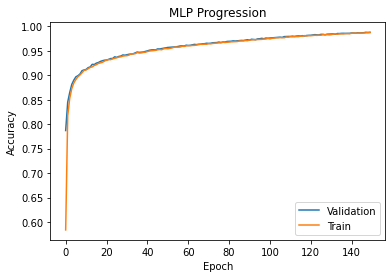

In [114]:
plt.plot(mlp_hist.history['val_sparse_categorical_accuracy'])
plt.plot(mlp_hist.history['sparse_categorical_accuracy'])
plt.title('MLP Progression')
plt.legend(['Validation', 'Train'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Accuracy')

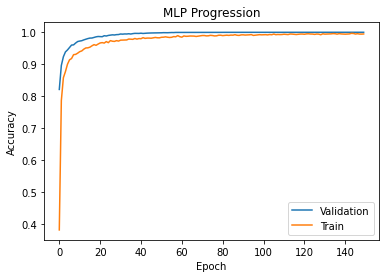

In [115]:
plt.plot(cnn_hist.history['val_sparse_categorical_accuracy'])
plt.plot(cnn_hist.history['sparse_categorical_accuracy'])
plt.title('MLP Progression')
plt.legend(['Validation', 'Train'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

#### Acurácia 

In [116]:
mlp_acc = mlp_model.evaluate(p_test)
cnn_acc = cnn_model.evaluate(p_test)

print('\nAcuracia do modleo MLP: {0:.2f}%'.format(mlp_acc[1] * 100))
print('Acuracia do modelo CNN: {0: .2f}%'.format(cnn_acc[1] * 100))

100/100 [==============================] - 0s 3ms/step - loss: 4.2221e-04 - sparse_categorical_accuracy: 0.9999

Acuracia do modleo MLP: 98.80%
Acuracia do modelo CNN:  99.99%


In [117]:
#Predict
mlp_pred = mlp_model.predict(p_test)
cnn_pred = cnn_model.predict(p_test)

#Get predicted y
mlp_pred_y = np.argmax(mlp_pred, axis=-1)
cnn_pred_y = np.argmax(cnn_pred, axis=-1)
#print(mlp_pred_y)
#print(cnn_pred_y)


#Get true y
true_y = [x[1].numpy() for x in list(test)]
#print(true_y)

#### Matriz de Confusão

Text(0.5, 1.0, 'Confusion Matrix')

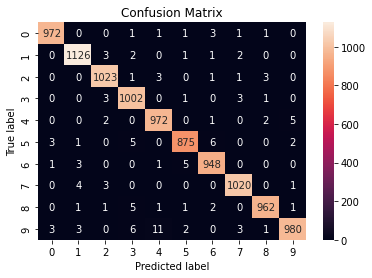

In [118]:
sns.heatmap(metrics.confusion_matrix(true_y, mlp_pred_y), annot=True, fmt='g')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')

Text(0.5, 1.0, 'Confusion Matrix')

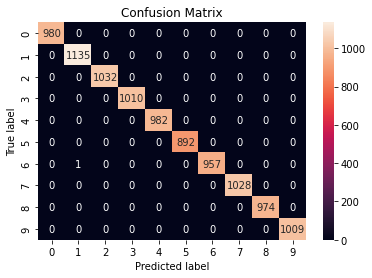

In [119]:
sns.heatmap(metrics.confusion_matrix(true_y, cnn_pred_y), annot=True, fmt='g')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')